In [149]:
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2025-01-03 по 2025-01-09 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные А/B-теста. 

1) Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2) Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
3) Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит. При выполнении задания важно обосновать и аргументировать ваш вывод.

Подготовим данные:

In [150]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20241220'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2024-11-22' and '2024-11-28'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [151]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


In [152]:
df.groupby('exp_group', as_index = False).count()

,exp_group,user_id,likes,views,ctr
0,1,10020,10020,10020,10020
1,2,9877,9877,9877,9877


Размеры групп примерно одинаковы, около 10000. Посмотрим на распределение ctr двух групп на графике:

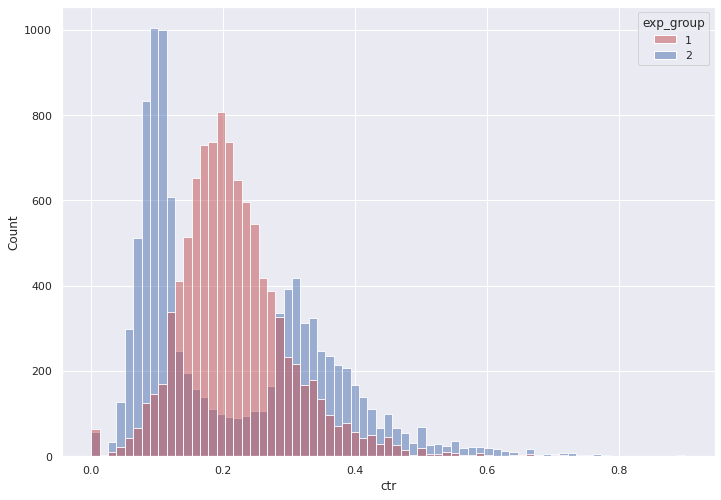

In [153]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Видим, что распределение контрольной группы похоже на нормальное, распределение тестовой группы бимодальное.

Среднее значение CTR контрольной группы:

In [154]:
df[df.exp_group == 1].ctr.mean()

0.216773994120072

Среднее значение CTR тестовой группы:

In [155]:
df[df.exp_group == 2].ctr.mean()

0.2161016893237817

### Применим t-тест:

У нас достаточно большой размер выборок, поэтому мы можем использовать этот критерий (единственное, что у меня вызывает сомнения - бимодальность одного из распределений, то есть тест мы используем, но к результатам относимся с подозрением).
##### Уровень значимости здесь и далее будем выбирать 0.05 

Нулевая гипотеза H0 : средние значений равны, значимых отклонений нет \
Альтернативная гипотеза H1 : средние значения не равны, есть значимые отклонения 

In [156]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

p = 0.69 > 0.05. T-тест не показал значимых различий.

### Применим критерий Манна-Уитни:

Нулевая гипотеза H0: P(X>Y) = P(Y>X) \
Альтернативная гипотеза H1: P(X>Y) != P(Y>X)

In [157]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr)

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [158]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B.')

В 55.48 % случаев A > B.


Можем сделать вывод, что были обнаружены статистически значимые различия, отклоняем нулевую гипотезу. Чаще всего значения одной из выборок (контрольной) оказываются больше значений другой выборки (тестовой).

### Используем сглаженный CTR:

In [159]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

Среднее значение сглаженного CTR контрольной группы:

In [160]:
group1['smothed_ctr'].mean()

0.21519217449299335

Среднее значение сглаженного CTR тестовой группы:

In [161]:
group2['smothed_ctr'].mean()

0.21259747775690932

Построим графики распределения CTR после сглаживания:

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='smothed_ctr'>

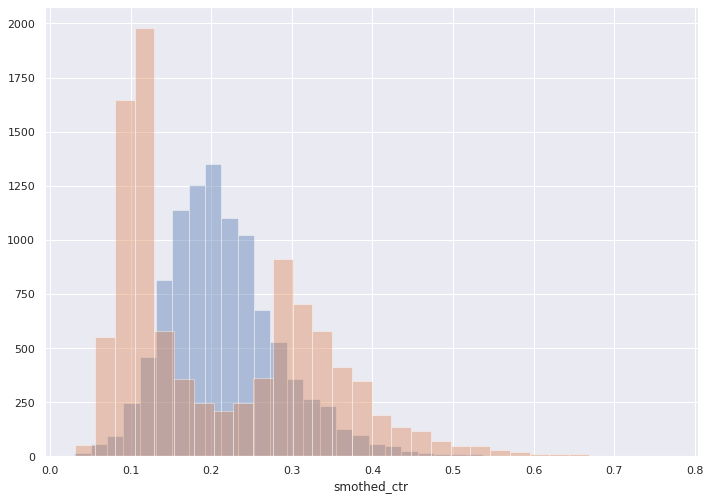

In [162]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(group1.smothed_ctr, bins = 30, kde = False)
sns.distplot(group2.smothed_ctr, bins = 30, kde = False)

Также рассмотрим распределение 1 и 2 группы до и после сглаживания:

<AxesSubplot:xlabel='smothed_ctr'>

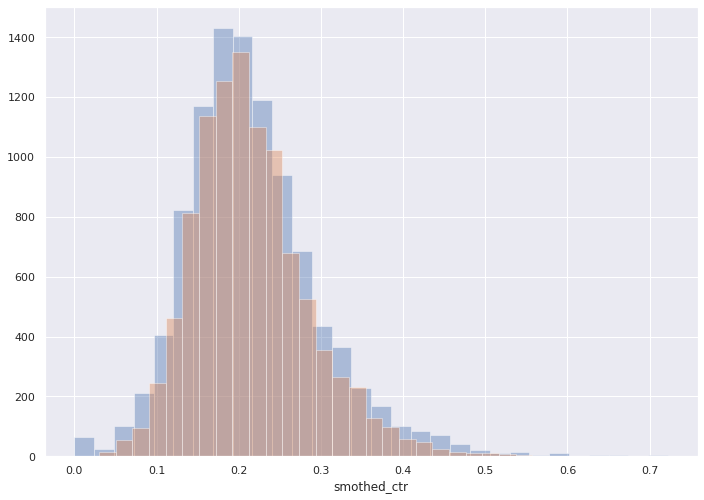

In [163]:
sns.distplot(df[df.exp_group == 1].ctr, bins = 30, kde = False)
sns.distplot(group1.smothed_ctr, bins = 30, kde = False)

<AxesSubplot:xlabel='smothed_ctr'>

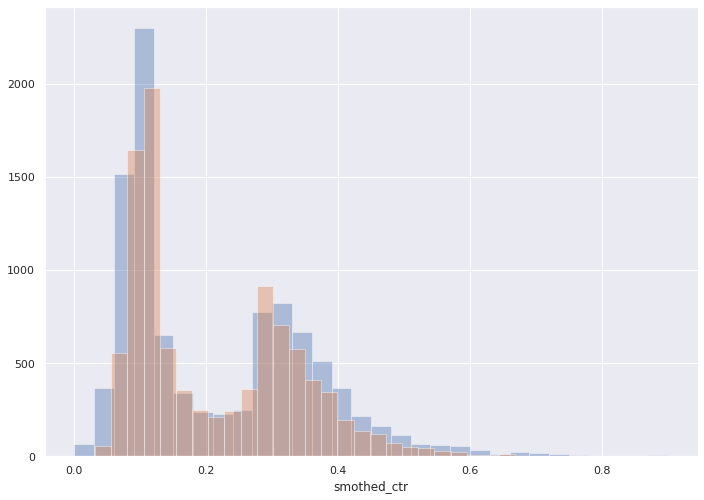

In [164]:
sns.distplot(df[df.exp_group == 2].ctr, bins = 30, kde = False)
sns.distplot(group2.smothed_ctr, bins = 30, kde = False)

Ожидаемо, выбросов после сглаживания стало меньше. Но распределение первой группы все так же похоже на нормальное, а распределение второй - бимодальное.

### Проведем для сглаженного CTR t-тест и тест Манна-Уитни:

In [165]:
stats.ttest_ind(group1['smothed_ctr'],
                group2['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=1.8218740616923907, pvalue=0.06849304751289614)

Для t-теста p = 0.052 > 0.05. Значение p стало ниже при сглаживании, но все еще недостаточно, чтобы отклонить нулевую гипотезу.

In [166]:
stats.mannwhitneyu(group1['smothed_ctr'],
                group2['smothed_ctr'],
                alternative = 'two-sided')

MannwhitneyuResult(statistic=55334061.0, pvalue=2.8295663785915355e-47)

In [167]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= group1['smothed_ctr'].sample().values[0] > group2['smothed_ctr'].sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B.')

В 55.83 % случаев A > B.


При проведении теста Манна-Уитни были обнаружены статистически значимые различия, отклоняем нулевую гипотезу. Чаще всего значения одной из выборок (контрольной) оказываются больше значений другой выборки (тестовой).

### Применим Пуассоновский бутстреп для сглаженного CTR:

Сравним общегрупповой CTR в группах A и B. Нагенерируем из каждой из этих выборок 10000 псевдовыборок с возвращением.

In [168]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=10000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [169]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

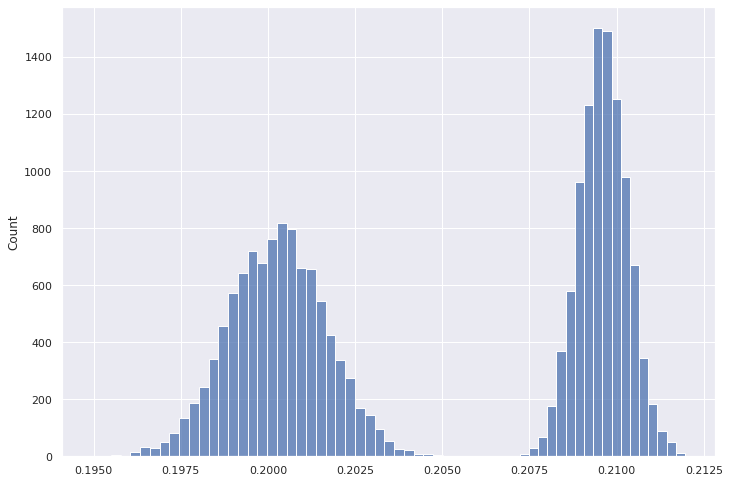

In [170]:
sns.histplot(ctr1, bins = 20)
sns.histplot(ctr2, bins = 40)

На графике видим, что отличия в CTR есть.

<AxesSubplot:ylabel='Count'>

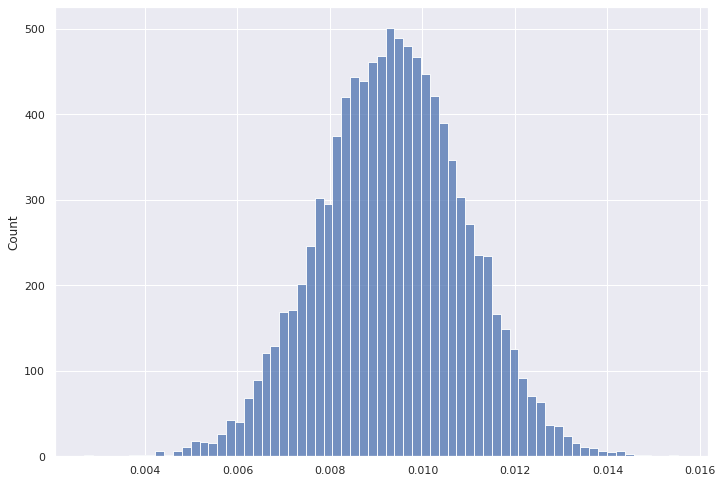

In [171]:
sns.histplot(ctr1 - ctr2)

Найдя разницу между глобальными CTR, видим, что значения в контрольной группе больше, чем в тестовой. Следовательно группа 1 показала лучше значения по CTR, чем группа 2.

### Проведем бакетного преобразования t-тест и тест Манна-Уитни:

In [172]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2024-11-22' and '2024-11-28'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

Построим график бакетного распределения CTR:

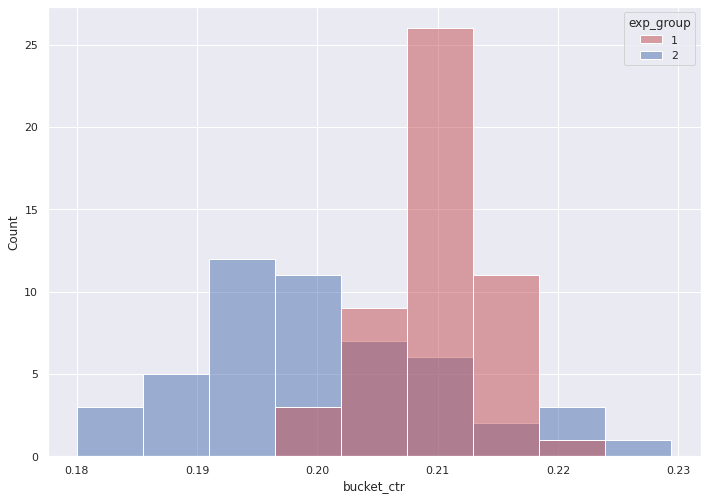

In [173]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Распределение бакетного CTR более-менее похоже на нормальное. Применим t-тест:

In [174]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

p << 0.05, t-тест показал статистически значимые различия. Применим тест Манна-Уитни:

In [175]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

Были обнаружены статистически значимые различия, отклоняем нулевую гипотезу

In [176]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].bucket_ctr.sample().values[0] > df[df.exp_group == 2].bucket_ctr.values[0]
    
print('В', A_gt_B/100, '% случаев A > B.')

В 100.0 % случаев A > B.


## Выводы:

В контрольной группе значения распределены нормально или почти нормально. В тестовой же группе бимодально, что может говорить о том, что на некоторых пользователях новый алгоритм работает хорошо, в то время как у других не вызывает интереса. Есть смысл разобраться, чем отличаются две эти группы пользователей, возможно, изменения стоит вносить только для тех, на ком эти изменения показывают хорошие результаты. \
Мы применили к нашим данным t-тест и тест Манна-Уитни. T-тест не показал значимых изменений, в то время как тест Манна-Уитни показал, что данные различаются и чаще значения контрольной группы оказываются выше значений тестовой. \
Для сглаженного CTR результаты тестов оказалсись похожими. Мы также применили Пуассоновский бутстреп, который показал, что значения контрольной группы больше значений тестовой. \
Для бакетного преобразования и t-тест, и тест Манна-Уитни показали значимые различия. \
T-тест может работать хуже для распределения тестовой группы, так как в нем сравниваются именно средние значения (в случае группы 2, мне кажется, лучше использовать медиану) и сам тест хуже, чем тест Манна-Уитни, справляется с данными, распределенными неравномерно. \
Я думаю, не стоит раскатывать новый алгоритм на всех новых пользователей. Все проведенные тесты показывали либо отсутствие значимых изменений, либо ухудшение метрик. Возможно стоит доработать алгоритм и запустить его более персонализировано.